In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import flow_sankey as sankey
from manuscript import datasets, inout, export


import itertools
import scipy.stats
# import statsmodels.stats.multitest
import statannotations.Annotator

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

# fonts = inout.get_resource_path('fonts')
# for f in os.listdir(fonts):
#     if f.endswith(".ttf"):
#         mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )
    


In [2]:

user = 'general'     # defines top hierarchy of output folder
outfolder = '08_VAP_flows'    # name of notebook


In [3]:

data = pd.read_csv(
    inout.get_material_path('CAG/05_join/05_data_umap_clusters_220901_1211.csv.gz'), 
    index_col=0)

In [4]:
# match old naming

data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

In [9]:
df=data.copy()

In [7]:
EPISODE_WINDOW = 2  # days

In [9]:
episode_dfs = []
for episode_type in ["CAP", "HAP", "VAP"]:
    dfs = []
    for day in range(-EPISODE_WINDOW, EPISODE_WINDOW + 1 + 5):
        days = data.day[data.Episode_category.eq(episode_type)] + day
        days = days[days > 0]
        idx = (
            data.patient[days.index].astype(str) 
            + "/" + data.stay[days.index].astype(str) 
            + "/" + days.astype(str)
        )
        idx = idx[idx.isin(data.index)]
        df = pd.DataFrame({
            "cluster_name": data.cluster[idx].values,
            "episode_type": data.Episode_category[idx.index].values,
            "day": day
        }, index=idx.index)
        full_idx = data.index[data.Episode_category.eq(episode_type) & data.Episode_etiology.ne("Viral")] #nonviral
        df = df.reindex(full_idx)
        df.loc[full_idx[~full_idx.isin(idx.index)], "day"] = day
        df.loc[full_idx[~full_idx.isin(idx.index)], "episode_type"] = episode_type
        df.loc[full_idx, "cured"] = data.Episode_is_cured[full_idx]
        df.loc[full_idx, "patient"] = data.patient[full_idx]
        df.loc[full_idx, "stay"] = data.stay[full_idx]
        dfs.append(df)
        
    df = pd.concat(dfs)
    episode_dfs.append(df)
    
df = pd.concat(episode_dfs)

In [10]:
df.cluster_name = df.cluster_name.astype(str)
df.cluster_name.replace({"nan": "-1"}, inplace=True)
df.cluster_name = df.cluster_name.astype("category")

In [11]:
df_ = data.copy()
df_["outcome"] = "Alive"
df_.loc[df_.Binary_outcome.eq("Died"), "outcome"] = "Dead"
last_stay_per_patient = df_.groupby("patient").agg({"stay": "max"})
df_["last_stay"] = last_stay_per_patient.stay[df_.patient].values
df_.loc[df_.stay != df_.last_stay, "outcome"] = "ICU readm."
patient_outcome = df_.set_index(["patient", "stay"]).groupby(["patient", "stay"]).head(1).outcome

In [12]:
def episodes_sankey(df, episode_type=None, cured=None):
    def flow_color(left, right):
        if left == right:
            return "correct"
        if left in ("Non-NMH", "Floor"):
            return "decrease"
        if right == "Alive":
            return "increase"
        if right == "Dead":
            return "mistake"
        if right == "ICU readm.":
            return "decrease"
        if left > right:
            return "increase"
        return "mistake"
    
    title = "All episodes"
    idx = pd.Series(True, index=df.index)
    if episode_type is not None:
        title = f"{episode_type} episodes only"
        idx = idx & df.episode_type.eq(episode_type)
    if cured is not None:
        title = f"{cured} episodes only"
        idx = idx & df.cured.eq(cured)
    if episode_type is not None and cured is not None:
        title = f"{cured} {episode_type} episodes only"
        
    sankey_df = df.reset_index().loc[
        idx.values, 
        ["index", "patient", "stay", "day", "cluster_name"]
    ].pivot(
        index=["index", "patient", "stay"],
        columns="day",
        values="cluster_name"
    ).reset_index()
    title += f" (n={sankey_df.shape[0]})"

    for c in sankey_df.columns[3:]:
        sankey_df[c] = sankey_df[c].astype(float).astype(int)

    for c in sankey_df.columns[3:]:
        idx = sankey_df[c].eq(-1)
        if c < 0:
            sankey_df.loc[idx & sankey_df.stay[idx].eq(1), c] = "Non-NMH"
            sankey_df.loc[idx & sankey_df.stay[idx].gt(1), c] = "Floor"
        else:
            outcome_idx = pd.MultiIndex.from_arrays([sankey_df.patient[idx], sankey_df.stay[idx]])
            sankey_df.loc[idx, c] = patient_outcome[outcome_idx].values

    colors = {
        i: mpl.cm.tab20(i - 1) 
        for i in range(1, 15)
    }
    colors["Non-NMH"] = "#999"
    colors["Floor"] = "#444"
    colors["ICU readm."] = "#444"
    colors["Alive"] = "#62b7d1"
    colors["Dead"] = "#ccc"
    fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
    diag = sankey.Sankey(
        sankey_df.iloc[:, 3:], 
        ax=ax, 
        order=["Non-NMH", "Floor", "Alive", "ICU readm."] + list(range(1, 15)) + ["Dead"],
        block_width=0.2,
        # flow_color_func=flow_color,
        colors=colors,
        alpha=0.5
    )
    diag.draw()
    ax.set_title(f"{title}\n–2 days, episode start, +7 days", size=16)
    ax.set_xticks(
        [diag.block_width / 2 + diag.flow_width * x + diag.block_width * x for x in range(sankey_df.shape[1] - 3)]
    )
    ax.set_xticklabels(sankey_df.columns[3:].astype(int))
    ax.set_xlabel("Day relative to episode onset", size=14)
    ax.get_xaxis().set_visible(True)
    ax.tick_params(axis="x", pad=5, labelsize=16)
    return ax

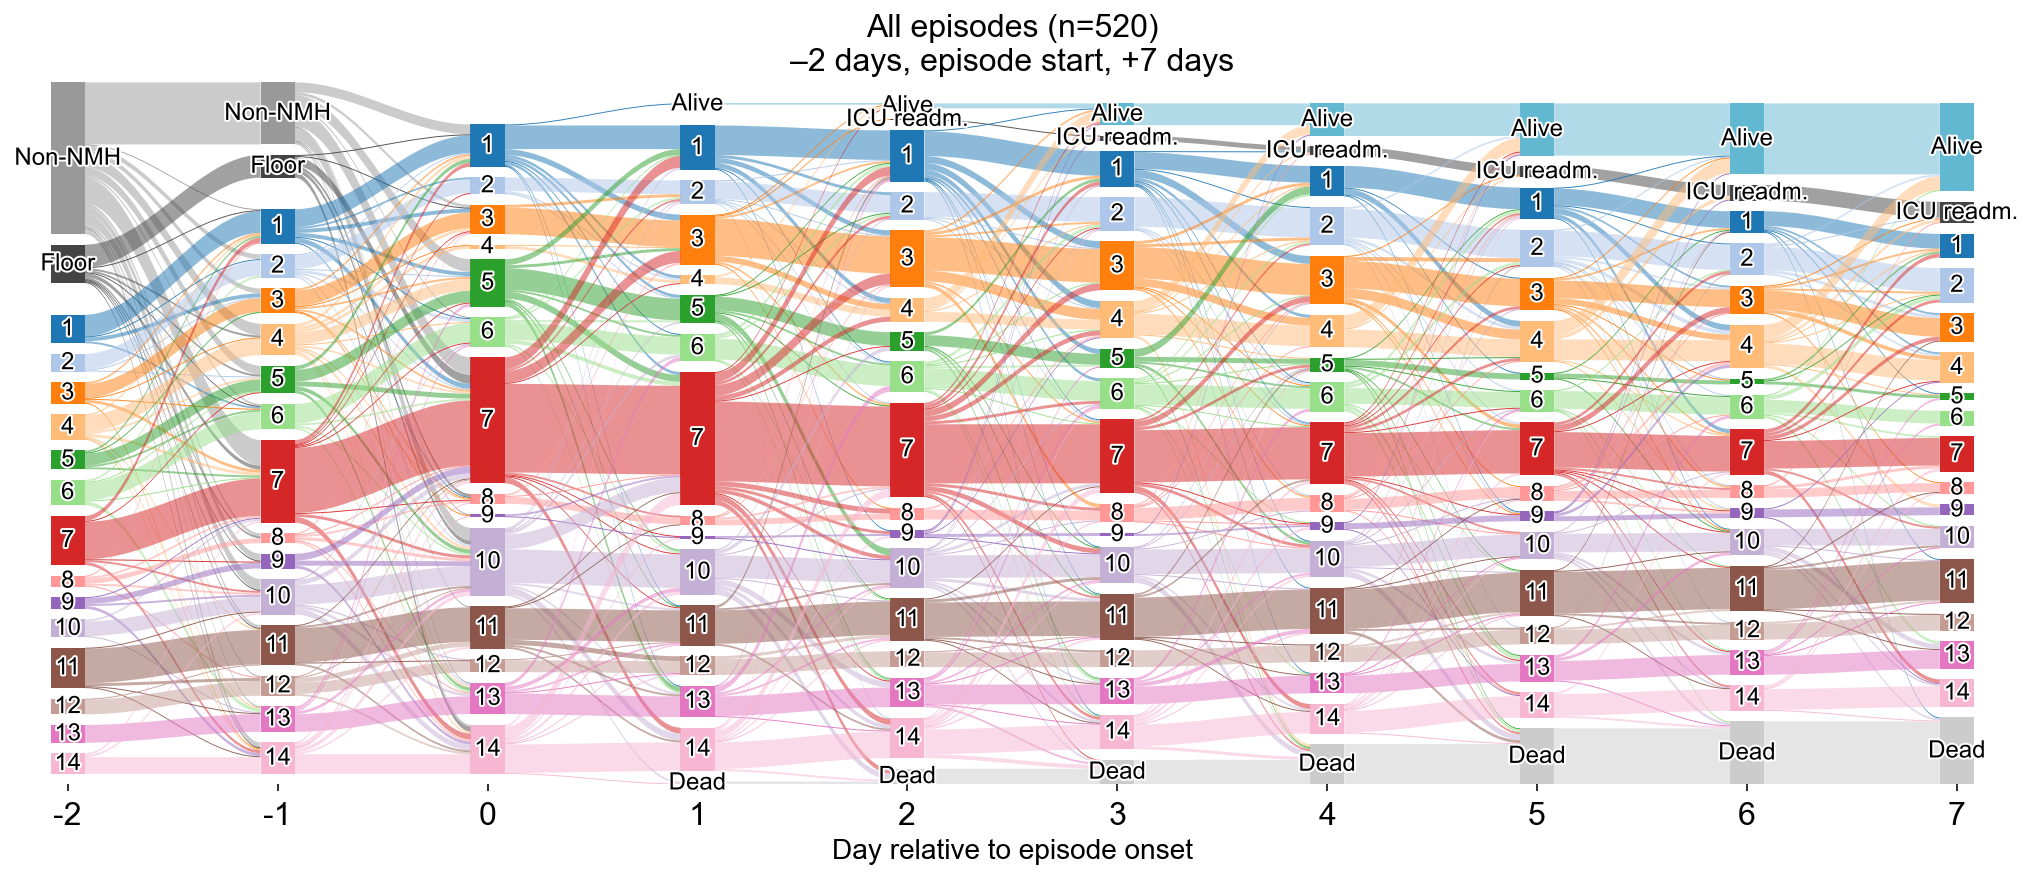

In [13]:
episodes_sankey(df);
dump_figure('sankey_all_episodes.pdf')

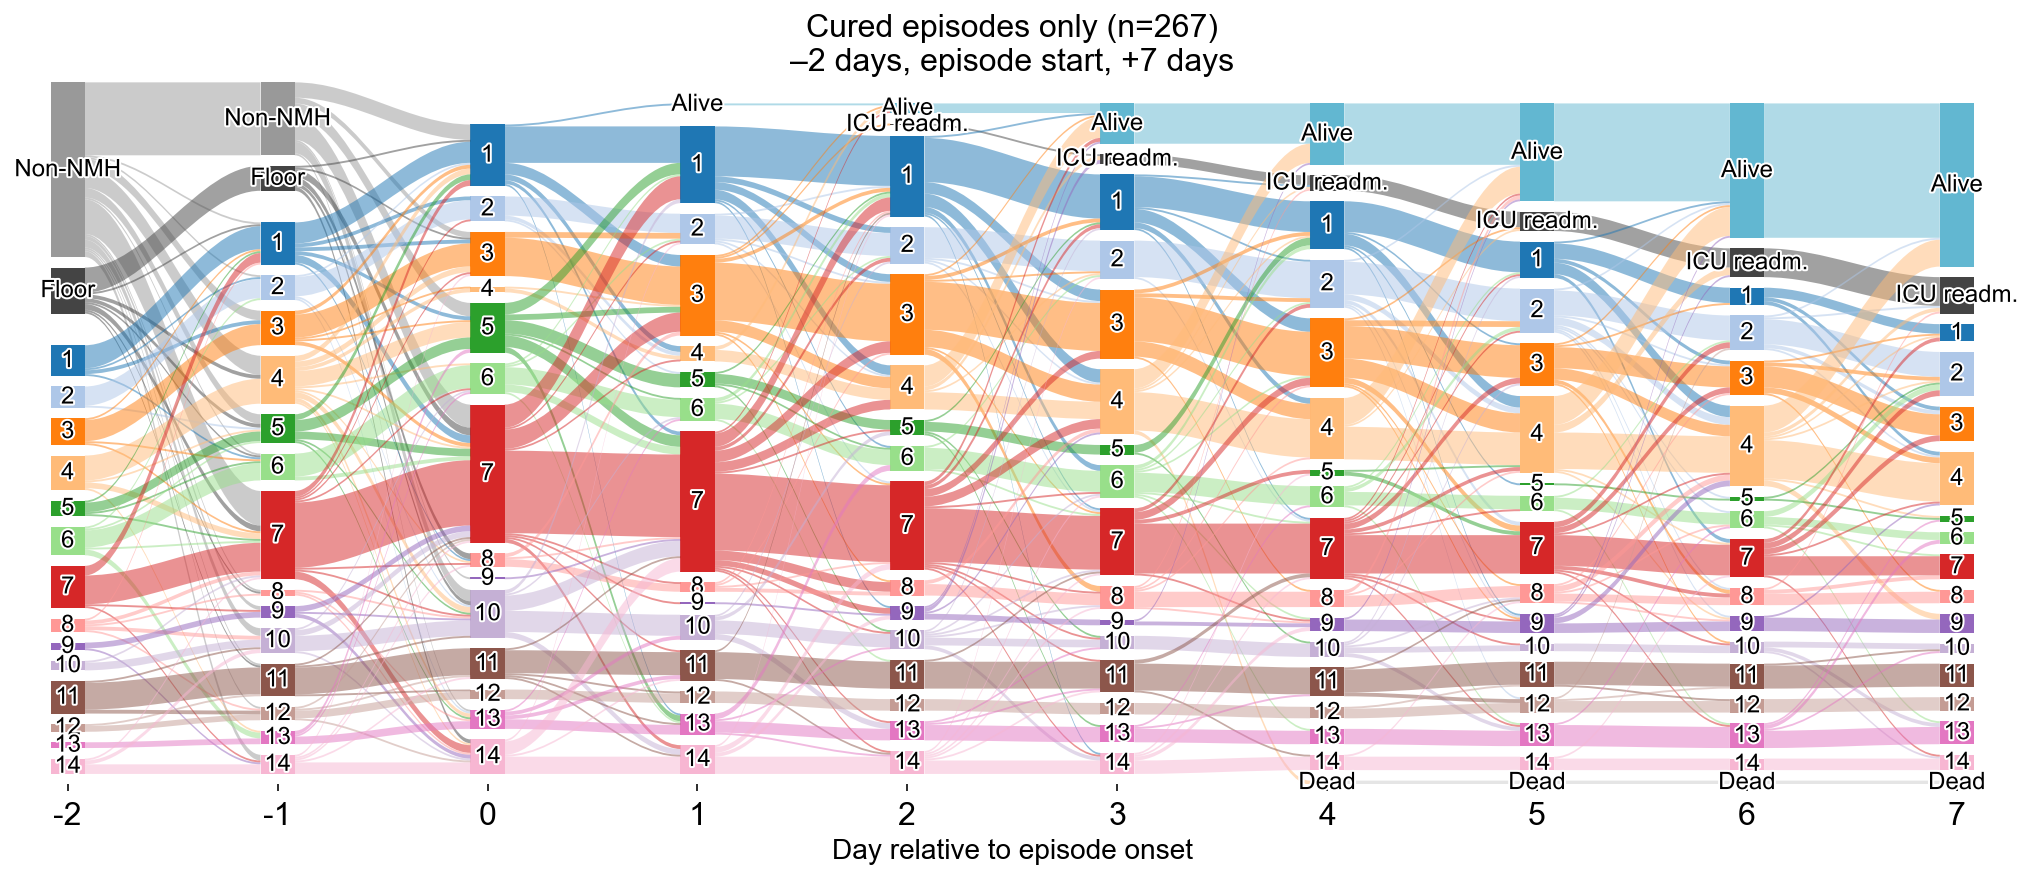

In [14]:
episodes_sankey(df, cured="Cured");
dump_figure('sankey_all_episodes_cured.pdf')

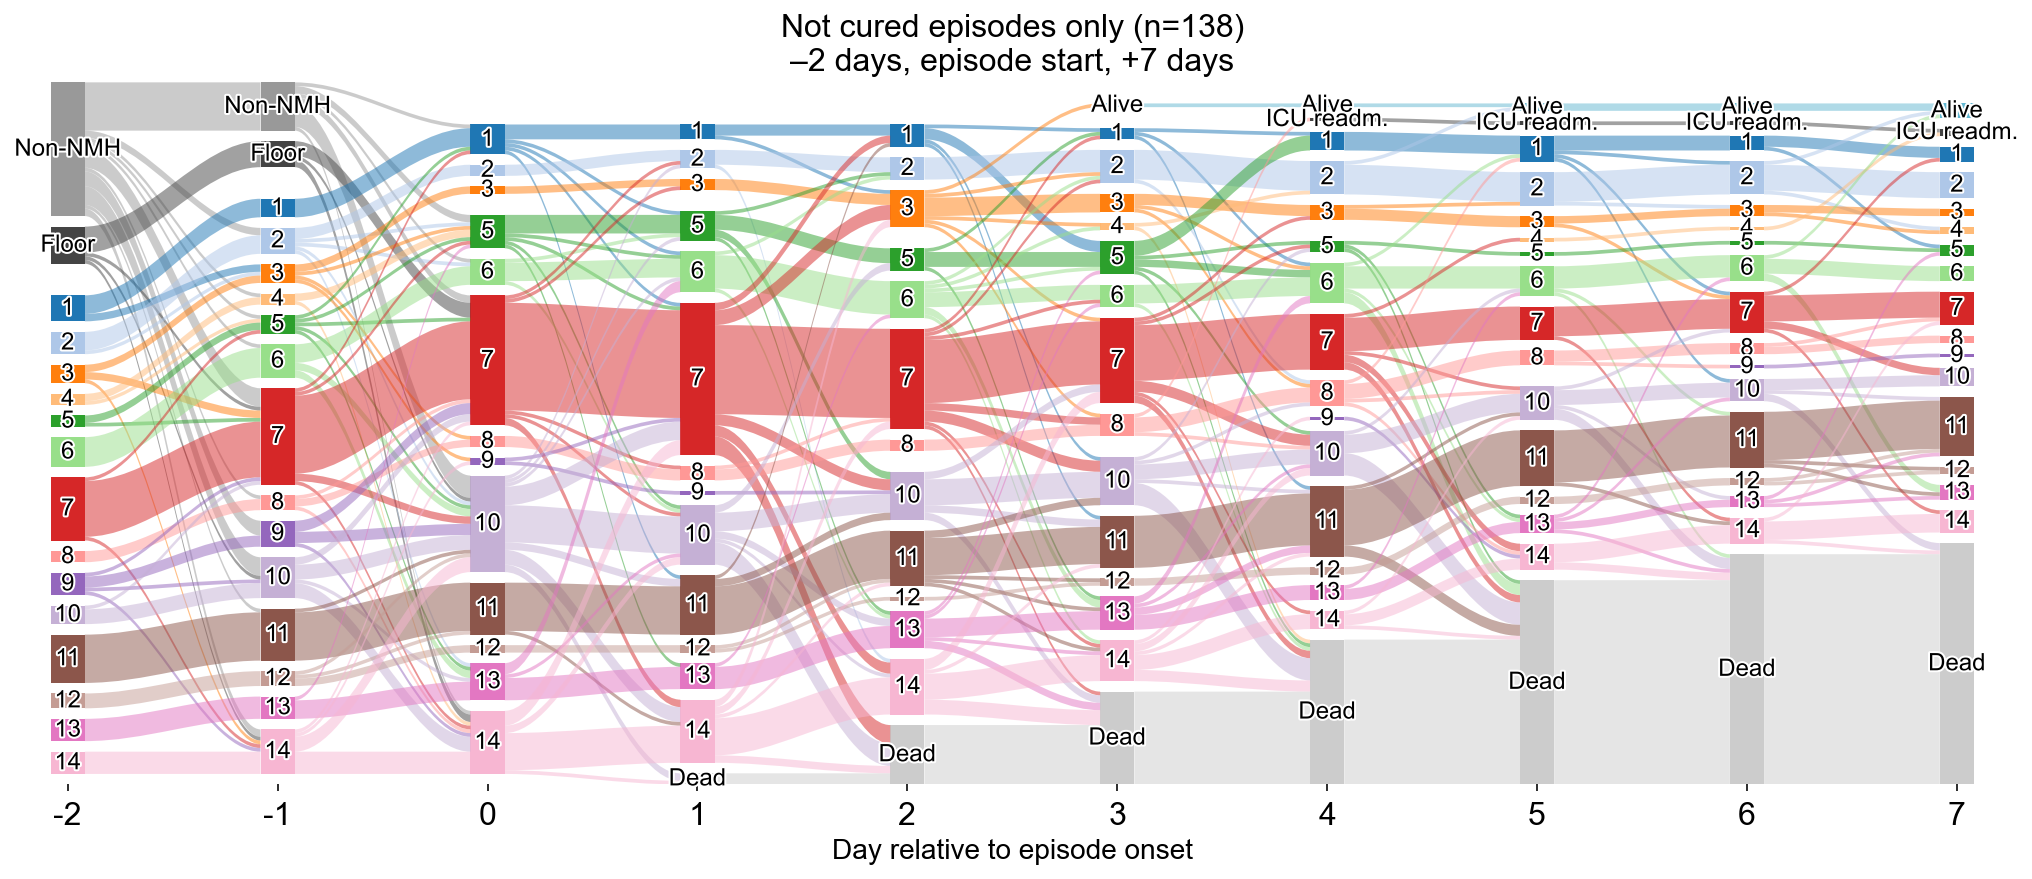

In [15]:
episodes_sankey(df, cured="Not cured");
dump_figure('sankey_all_episodes_not_cured.pdf')

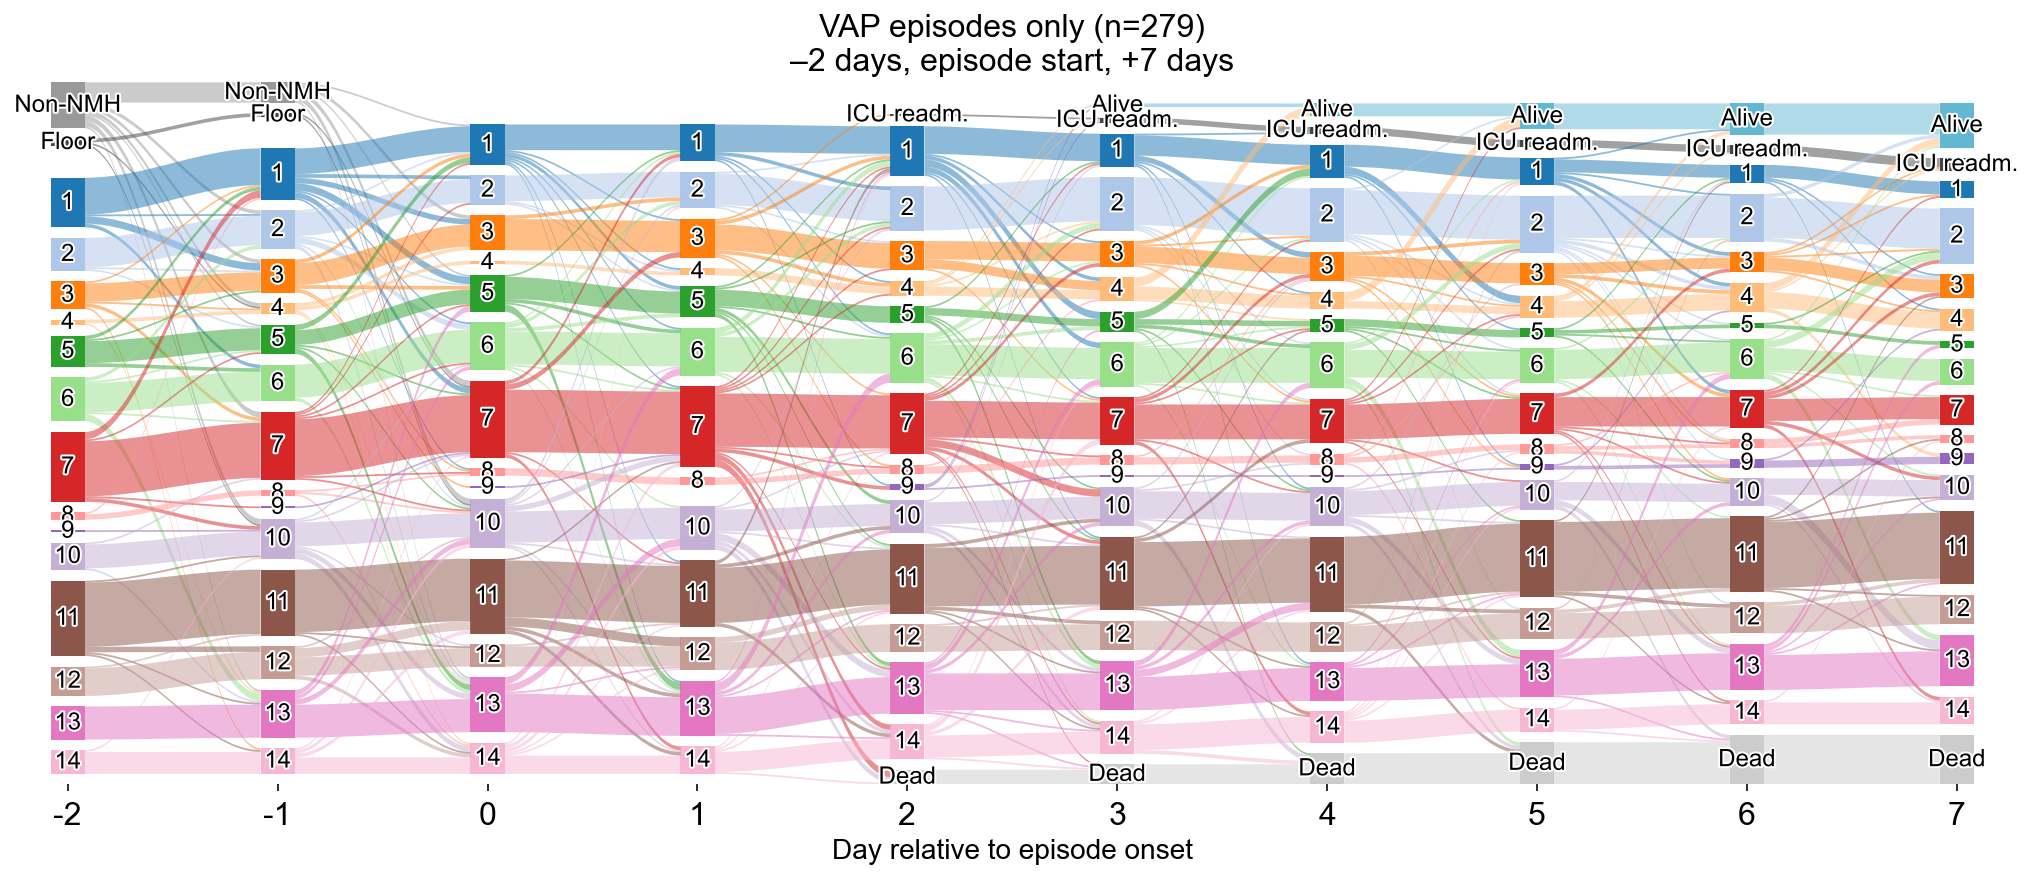

In [16]:
episodes_sankey(df, episode_type="VAP");
dump_figure('sankey_all_vap.pdf')

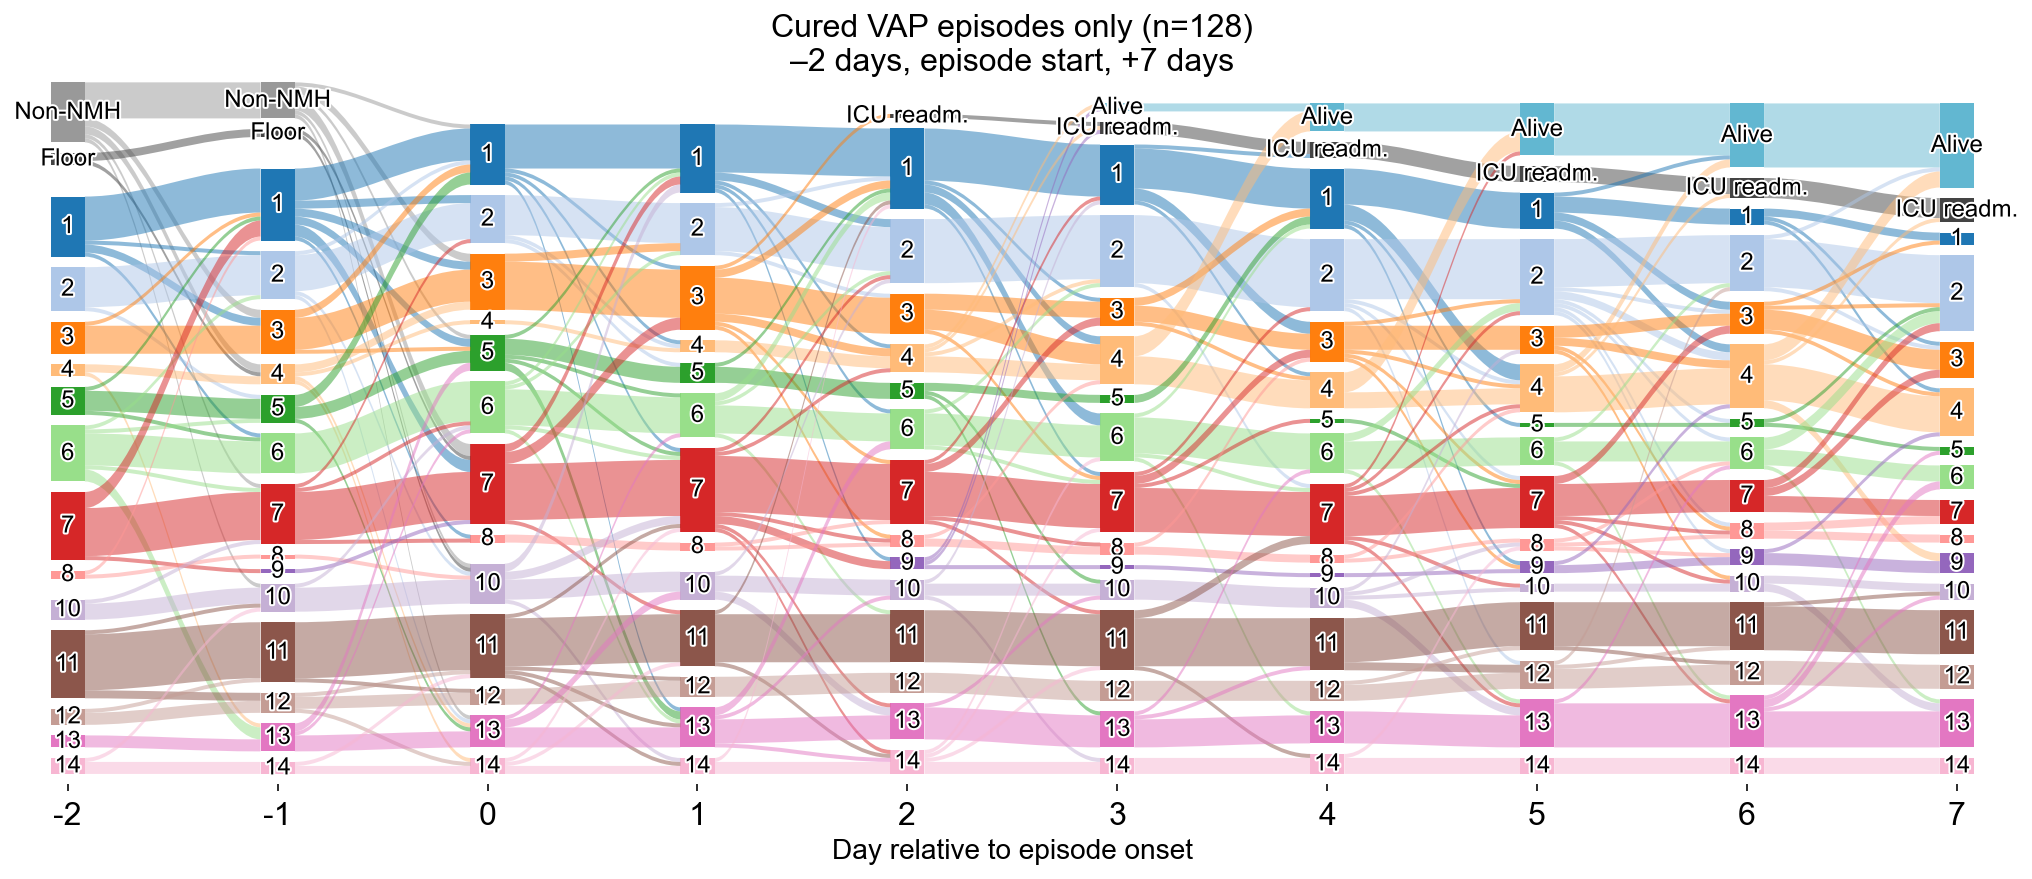

In [17]:
episodes_sankey(df, episode_type="VAP", cured="Cured");
dump_figure('sankey_cured_vap.pdf')

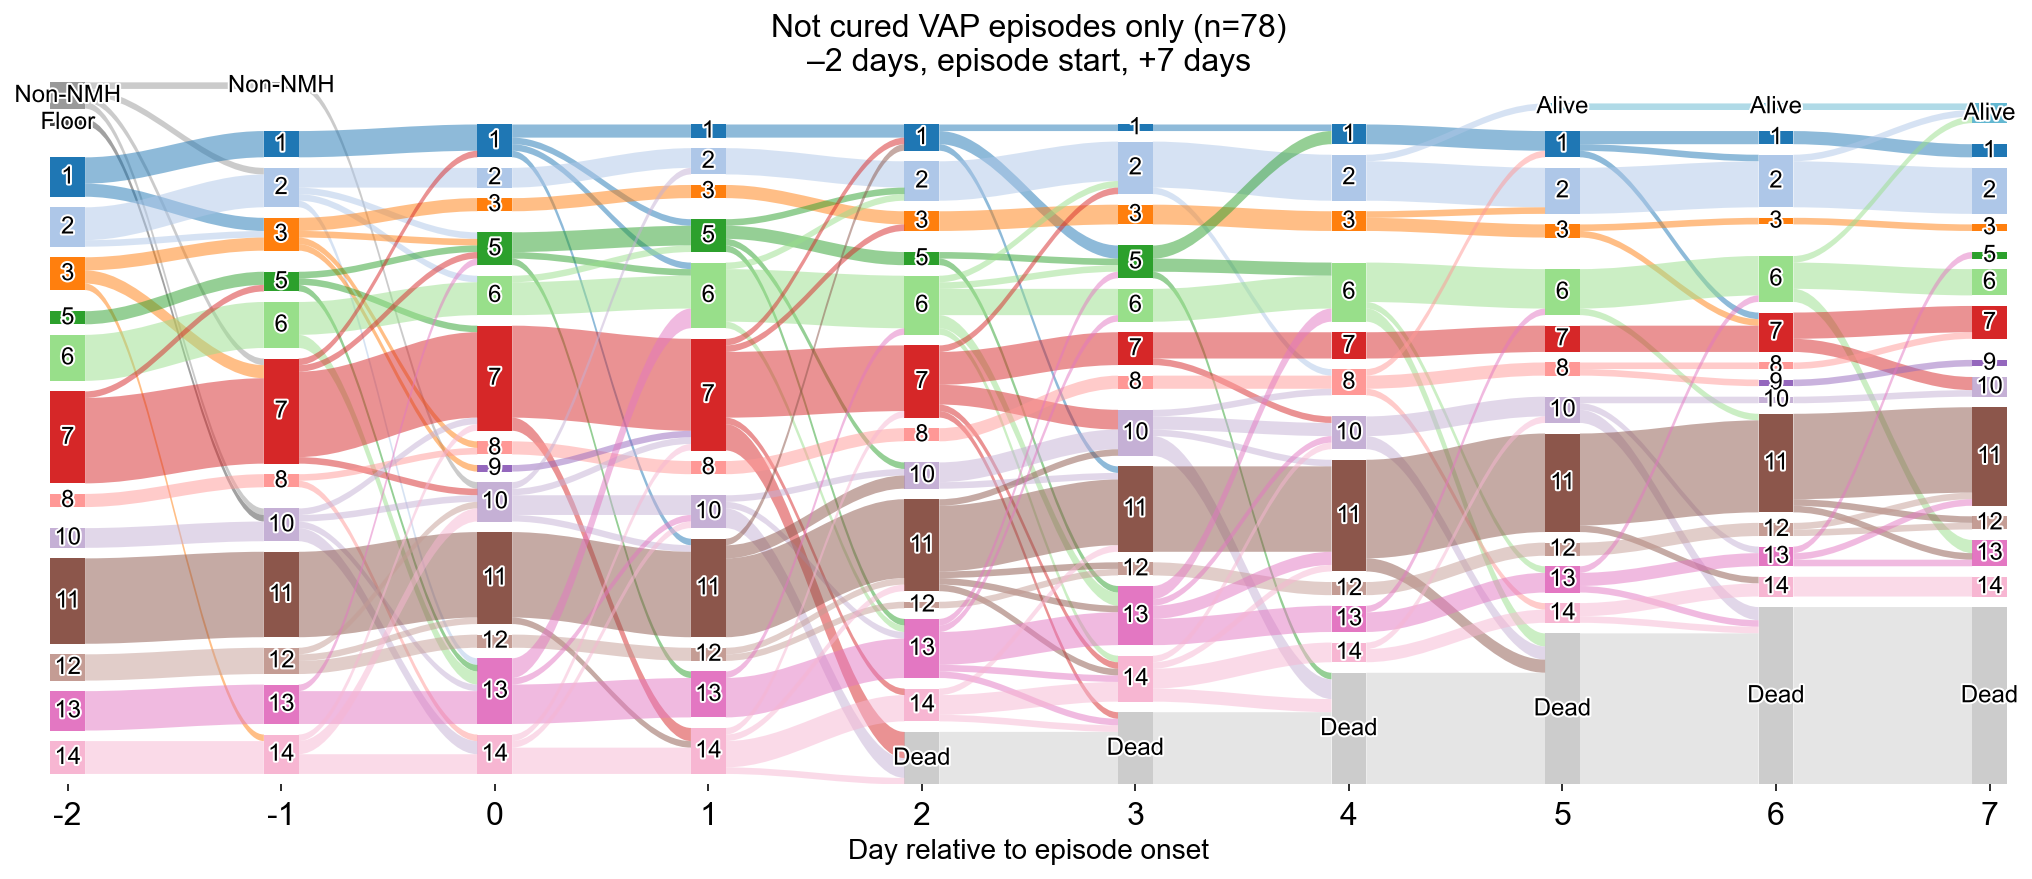

In [18]:
episodes_sankey(df, episode_type="VAP", cured="Not cured");
dump_figure('sankey_notcured_vap.pdf')

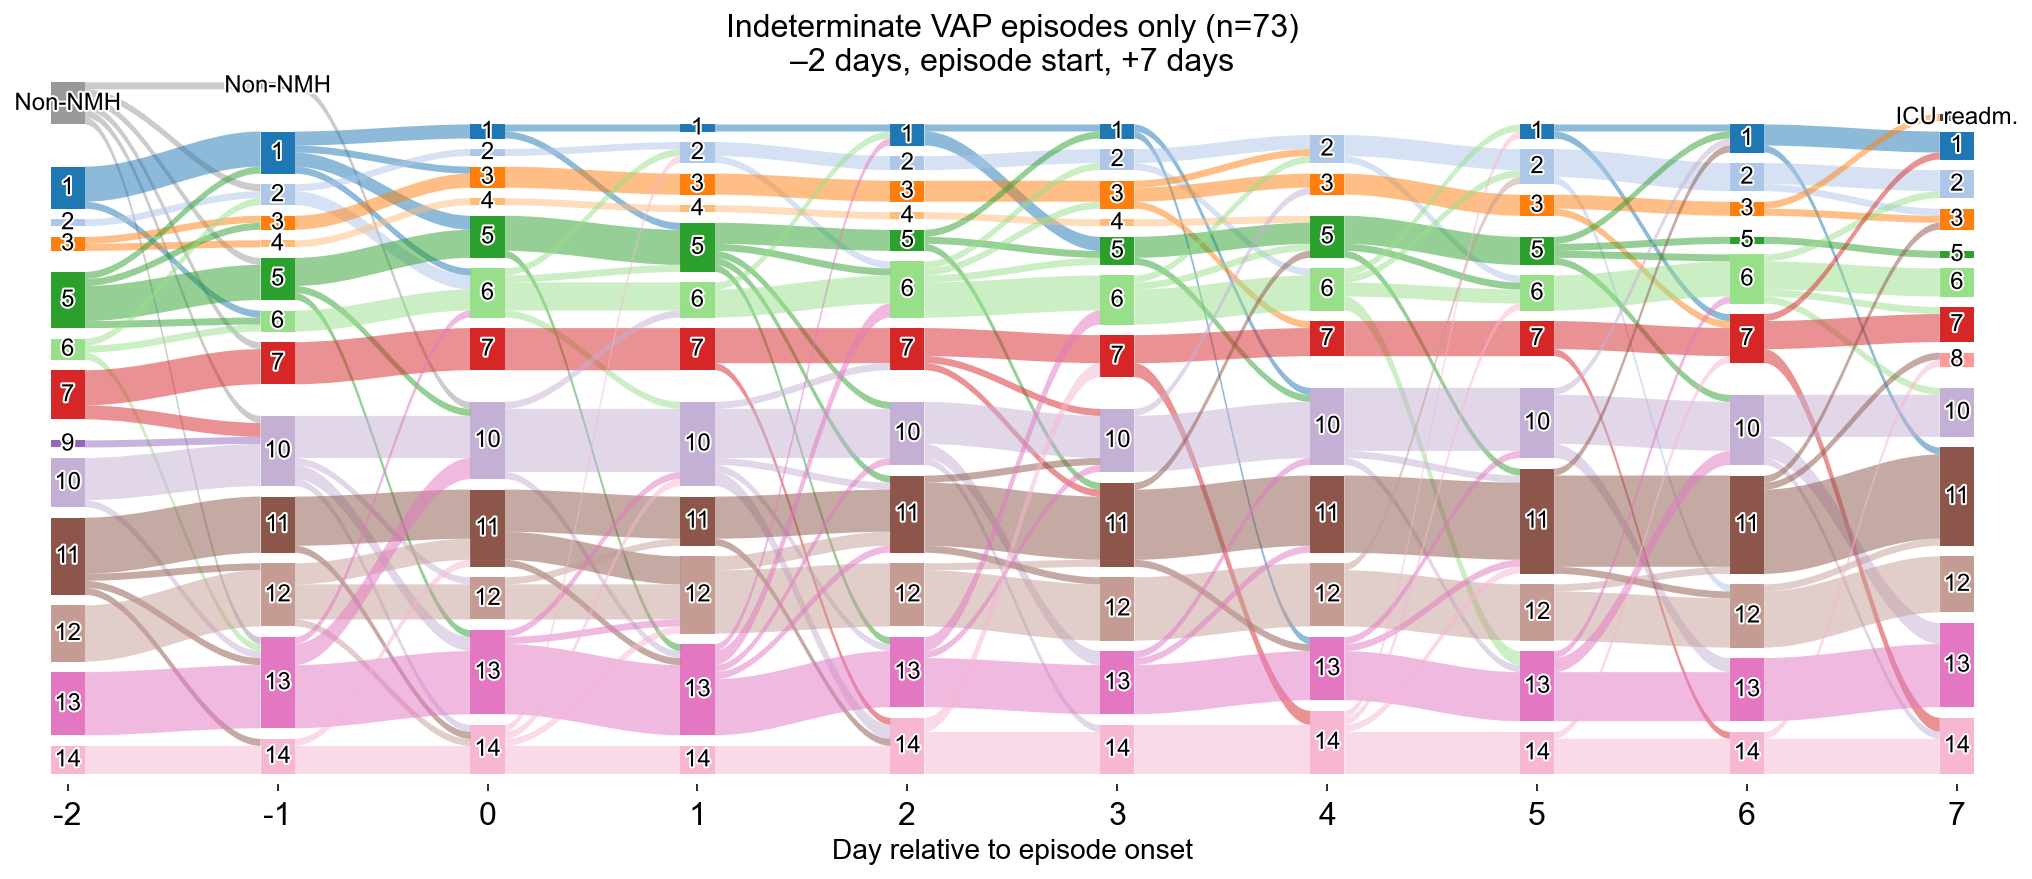

In [19]:
episodes_sankey(df, episode_type="VAP", cured="Indeterminate");
dump_figure('sankey_indeterminate_vap.pdf')